# io-lulc-9-class dataset issue

The end goal of this workflow is to get the percentage of crop land for a set of points associated with the surrounding 1 $km^2$ regions. The percentage of crop land will then be added as a column to the features created with the mosaiks notebook at the same points. The percentage crop land of a point will be used as a wieght for the weighted average of features inside of an administrative boundary, in this example, the districts inside the country of Zambia. 

This general workflow is ideal for our use only in the sense that it matches well with the mosaiks example notebook and would integrate nicely into the work we have done to build from that baseline. That being said, we are open to other methods which give us our desired reults. 

This notebook reproduces an issue where the workflow produces empty values at the UTM zones delineations at every $6^o$ longitude. It also causes empty values at every $8^o$ latitude. We were able to solve the issue with the vertical lines of empty values but not with the horizontal lines. 

In [1]:
!pip install -q git+https://github.com/geopandas/dask-geopandas
RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
import os
import time
os.environ.update(RASTERIO_BEST_PRACTICES)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import rasterio
import rasterio.warp
import rasterio.mask
import shapely.geometry
import geopandas
import dask_geopandas
from dask.distributed import Client
from pystac.extensions.item_assets import ItemAssetsExtension
import pystac_client
import planetary_computer as pc

### Create a sparse grid of points over Zambia 

In [2]:
# Set params
country_code = 'ZMB'
year = 2021
geodetic_epsg = 'EPSG:4326'
# get country shape
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
country = world.query(f'iso_a3 == "{country_code}"')
# Create grid of points
cell_size = .15  # Very roughly 10 km
xmin, ymin, xmax, ymax = country.total_bounds
xs = list(np.arange(xmin, xmax + cell_size, cell_size))
ys = list(np.arange(ymin, ymax + cell_size, cell_size))
def make_cell(x, y, cell_size):
    ring = [
        (x, y),
        (x + cell_size, y),
        (x + cell_size, y + cell_size),
        (x, y + cell_size)
    ]
    cell = shapely.geometry.Polygon(ring).centroid
    return cell
points = []
for x in xs:
    for y in ys:
        cell = make_cell(x, y, cell_size)
        points.append(cell)
# Put grid into a GeDataFrame
gdf = geopandas.GeoDataFrame({'geometry': points}, crs = geodetic_epsg)
gdf['lon'], gdf['lat'] = gdf.geometry.x, gdf.geometry.y
# subset to country 
# gdf = gdf[gdf.within(country.unary_union)]
gdf = gdf[['lon', 'lat', 'geometry']].reset_index(drop = True)

In [3]:
gdf.shape

(5214, 3)

### Sort by hilbert distance

In [4]:
# sort by hilbert distance
NPARTITIONS = 250
ddf = dask_geopandas.from_geopandas(gdf, npartitions=1)
hd = ddf.hilbert_distance().compute()
gdf["hd"] = hd
gdf = gdf.sort_values("hd")
dgdf = dask_geopandas.from_geopandas(gdf, npartitions=NPARTITIONS, sort=False)

### Find the value for Crops in the io-lulc-9-class dataset

In [5]:
# Get the value for Crop land in the data
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
collection = catalog.get_collection("io-lulc-9-class")
ia = ItemAssetsExtension.ext(collection)
x = ia.item_assets["data"]
class_names = {x["summary"]: x["values"][0] for x in x.properties["file:values"]}
values_to_classes = {v: k for k, v in class_names.items()}
crop_value = class_names['Crops']

### Create the query

In [6]:
# Define the query
def query(points):
    """
    Find a STAC item for points in the `points` DataFrame

    Parameters
    ----------
    points : geopandas.GeoDataFrame
        A GeoDataFrame

    Returns
    -------
    geopandas.GeoDataFrame
        A new geopandas.GeoDataFrame with a `stac_item` column containing the STAC
        item that covers each point.
    """
    intersects = shapely.geometry.mapping(points.unary_union.convex_hull)
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["io-lulc-9-class"],
        intersects=intersects,
        datetime=["2019-01-01", "2019-12-31"],
    )
    ic = search.get_all_items_as_dict()
    features = ic["features"]
    features_d = {item["id"]: item for item in features}
    data = {"geometry": [],}
    index = []
    for item in features:
        data["geometry"].append(shapely.geometry.shape(item["geometry"]))
        index.append(item["id"])
    items = geopandas.GeoDataFrame(data, index=index, geometry="geometry")
    point_list = points.geometry.tolist()
    point_items = []
    for point in point_list:
        covered_by = items[items.covers(point)]
        if len(covered_by):
            point_items.append(features_d[covered_by.index[0]])
        else:
            # There weren't any scenes matching our conditions for this point (too cloudy)
            point_items.append(None)

    return points.assign(stac_item=point_items)

### Match points to images

In [7]:
with Client(n_workers=16) as client:
    meta = dgdf._meta.assign(stac_item=[])
    df2 = dgdf.map_partitions(query, meta=meta).compute()
df3 = df2.dropna(subset=["stac_item"]).reset_index()
# matching_urls = [
#     pc.sign(item["assets"]["data"]["href"]) for item in df3.stac_item.tolist()
# ]
# Define the points list 
points = df3[["lon", "lat"]].to_numpy()

### Define the custom dataset and data loader

In [8]:
# class CustomDataset(Dataset):
#     def __init__(self, points, fns, buffer=500):
#         self.points = points
#         self.fns = fns
#         self.buffer = buffer

#     def __len__(self):
#         return self.points.shape[0]

#     def __getitem__(self, idx):

#         lon, lat = self.points[idx]
#         fn = self.fns[idx]
        
#         if fn is None:
#             return None
#         else:
#             point_geom = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))
            
#             with rasterio.Env():
#                 with rasterio.open(fn, "r") as f:
#                     point_geom = rasterio.warp.transform_geom(
#                         "epsg:4326", 
#                         f.crs.to_string(),
#                         point_geom
#                     )
#                     point_shape = shapely.geometry.shape(point_geom)
#                     mask_shape = point_shape.buffer(self.buffer).envelope
#                     mask_geom = shapely.geometry.mapping(mask_shape)
#                     try:
#                         out_image, out_transform = rasterio.mask.mask(
#                             f, [mask_geom], crop=True
#                         )
#                     except ValueError as e:
#                         if "Input shapes do not overlap raster." in str(e):
#                             return None

#             out_image = out_image.squeeze()
#             out_image = torch.from_numpy(out_image).float()
#             return out_image
# # Create the dataset
# dataset = CustomDataset(points, matching_urls)
# dataloader = DataLoader(
#     dataset,
#     batch_size=8,
#     shuffle=False,
#     num_workers=os.cpu_count()*2,
#     collate_fn=lambda x: x,
#     pin_memory=False,
# )

### Calculate the percentage of cropped area around each 1 km region

In [9]:
# %%time
# x_all = np.zeros((points.shape[0], 1), dtype=float)
# tic = time.time()
# i = 0
# for images in dataloader:
#     for image in images:

#         if type(image) == torch.Tensor:  #### This was added because of the empty points
#             crops = (image == crop_value).sum() / image.numel()
#             x_all[i] = crops.item()
#         else:
#             x_all[i] = float("NaN")
            
#         if i % 3000 == 0:
#             print(
#                 f"{i}/{points.shape[0]} -- {i / points.shape[0] * 100:0.2f}%"
#                 + f" -- {time.time()-tic:0.2f} seconds"
#             )
#             tic = time.time()
#         i += 1

### Plot the results

In [10]:
# crops = pd.DataFrame({'crop_perc': x_all.squeeze()})
# crops[["lon", "lat"]] = points.tolist()
# plt.figure(figsize = (12,10))
# plt.scatter(crops.lon, crops.lat, c=crops.crop_perc, 
#             # s=16   ,
#             marker=","
#            )

### Manually fix the vertical lines caused by the UTM zone delineation

In [11]:
# class CustomDataset(Dataset):
#     def __init__(self, points, fns, buffer=500):
#         self.points = points
#         self.fns = fns
#         self.buffer = buffer

#     def __len__(self):
#         return self.points.shape[0]

#     def __getitem__(self, idx):

#         lon, lat = self.points[idx]
#         fn = self.fns[idx]
        
#         if lon >= 18.0 and lon < 24.0: ##### This fix does not scale well globally 
#             epsg = 32734
#         elif lon >= 24.0 and lon < 30.0:
#             epsg = 32735
#         else:
#             epsg = 32736
        
#         if fn is None:
#             return None
#         else:
#             point_geom = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))
            
#             with rasterio.Env():
#                 with rasterio.open(fn, "r") as f:
#                     point_geom = rasterio.warp.transform_geom(
#                         "epsg:4326", 
#                         epsg,               ###### If I set this manually based on the if statement above it 
#                         # f.crs.to_string(),###### solves the vertical gaps, but not the horizontal gaps
#                         point_geom
#                     )
#                     point_shape = shapely.geometry.shape(point_geom)
#                     mask_shape = point_shape.buffer(self.buffer).envelope
#                     mask_geom = shapely.geometry.mapping(mask_shape)
#                     try:
#                         out_image, out_transform = rasterio.mask.mask(
#                             f, [mask_geom], crop=True
#                         )
#                     except ValueError as e:
#                         if "Input shapes do not overlap raster." in str(e):
#                             return None

#             out_image = out_image.squeeze()
#             out_image = torch.from_numpy(out_image).float()
#             return out_image
# # Create the dataset
# dataset = CustomDataset(points, matching_urls)
# dataloader = DataLoader(
#     dataset,
#     batch_size=8,
#     shuffle=False,
#     num_workers=os.cpu_count()*2,
#     collate_fn=lambda x: x,
#     pin_memory=False,
# )
# # Calculate the percentage of cropped area around each 1 km region
# x_all = np.zeros((points.shape[0], 1), dtype=float)
# i = 0
# for images in dataloader:
#     for image in images:

#         if type(image) == torch.Tensor:  #### This was added because of the empty points
#             crops = (image == crop_value).sum() / image.numel()
#             x_all[i] = crops.item()
#         else:
#             x_all[i] = float("NaN")
#         if i % 3000 == 0:
#             print(
#                 f"{i}/{points.shape[0]} -- {i / points.shape[0] * 100:0.2f}%"
#                 + f" -- {time.time()-tic:0.2f} seconds"
#             )
#             tic = time.time()
#         i += 1

In [12]:
# crops = pd.DataFrame({'crop_perc': x_all.squeeze()})
# crops[["lon", "lat"]] = points.tolist()
# plt.figure(figsize = (12,10))
# plt.scatter(crops.lon, crops.lat, c=crops.crop_perc, 
#             # s=15,
#             marker=","
#            )

In [13]:
import warnings

from pystac import Item
import stackstac
import pyproj
from pystac.extensions.raster import RasterExtension as raster
from pystac.extensions.projection import ProjectionExtension as proj

warnings.filterwarnings(action="ignore", category=FutureWarning)

In [14]:
matching_items = []
for item in df3.stac_item.tolist():
    signed_item = pc.sign(Item.from_dict(item))
    matching_items.append(signed_item)

In [21]:
class CustomDataset(Dataset):
    def __init__(self, points, fns, buffer=500):
        self.points = points
        self.fns = fns
        self.buffer = buffer

    def __len__(self):
        return self.points.shape[0]

    def __getitem__(self, idx):

        lon, lat = self.points[idx]
        fn = self.fns[idx]

        if fn is None:
            return None
        else:        

            if lon >= 18.0 and lon < 24.0: ##### This fix does not scale well globally 
                epsg = 32734
            elif lon >= 24.0 and lon < 30.0:
                epsg = 32735
            else:
                epsg = 32736
            
            stack = stackstac.stack(
                fn,
                dtype=np.ubyte,
                fill_value=255,
                epsg = epsg
            )
            
            x_utm, y_utm = pyproj.Proj(stack.crs)(lon, lat)
            aoi = stack.loc[..., y_utm+self.buffer:y_utm-self.buffer, x_utm-self.buffer:x_utm+self.buffer]
            data = aoi.compute(scheduler="single-threaded")
            out_image = data.data 
            
            out_image = out_image.squeeze()
            out_image = torch.from_numpy(out_image).float()
            return out_image

In [22]:
dataset = CustomDataset(points, matching_items)

In [23]:
img = dataset[0]
img

tensor([[11., 11., 11.,  ..., 11., 11., 11.],
        [11., 11., 11.,  ..., 11., 11., 11.],
        [11., 11., 11.,  ..., 11., 11., 11.],
        ...,
        [11., 11., 11.,  ..., 11., 11., 11.],
        [11., 11., 11.,  ..., 11., 11., 11.],
        [11., 11., 11.,  ..., 11., 11., 11.]])

In [24]:
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=False,
    num_workers=os.cpu_count()*2,
    collate_fn=lambda x: x,
    pin_memory=False,
)

/srv/conda/envs/notebook/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
%%time
x_all = np.zeros((points.shape[0], 1), dtype=float)
tic = time.time()
i = 0
for images in dataloader:
    for image in images:

        if type(image) == torch.Tensor:  #### This was added because of the empty points
            crops = (image == crop_value).sum() / image.numel()
            x_all[i] = crops.item()
        else:
            x_all[i] = float("NaN")
            
        if i % 500 == 0:
            print(
                f"{i}/{points.shape[0]} -- {i / points.shape[0] * 100:0.2f}%"
                + f" -- {time.time()-tic:0.2f} seconds"
            )
            tic = time.time()
        i += 1

0/5214 -- 0.00% -- 5.51 seconds
500/5214 -- 9.59% -- 46.40 seconds
1000/5214 -- 19.18% -- 47.75 seconds
1500/5214 -- 28.77% -- 51.76 seconds
2000/5214 -- 38.36% -- 116.12 seconds
2500/5214 -- 47.95% -- 49.65 seconds
3000/5214 -- 57.54% -- 52.78 seconds
3500/5214 -- 67.13% -- 46.50 seconds
4000/5214 -- 76.72% -- 115.67 seconds
4500/5214 -- 86.31% -- 50.87 seconds
5000/5214 -- 95.90% -- 52.14 seconds
CPU times: user 1.21 s, sys: 481 ms, total: 1.69 s
Wall time: 10min 50s


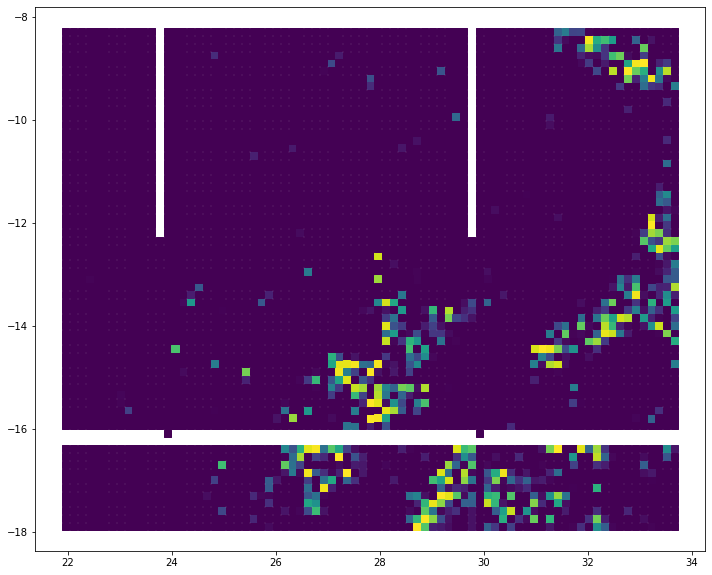

In [29]:
crops = pd.DataFrame({'crop_perc': x_all.squeeze()})
crops[["lon", "lat"]] = points.tolist()
plt.figure(figsize = (12,10))
plt.scatter(crops.lon, crops.lat, c=crops.crop_perc, 
            s=50,
            marker=","
           )